   age  gender marital_status education_level  annual_income  monthly_income  \
0   59    Male        Married        Master's       24240.19         2020.02   
1   72  Female        Married      Bachelor's       20172.98         1681.08   
2   49  Female         Single     High School       26181.80         2181.82   
3   35  Female         Single     High School       11873.84          989.49   
4   63   Other         Single           Other       25326.44         2110.54   

  employment_status  debt_to_income_ratio  credit_score  loan_amount  ...  \
0          Employed                 0.074           743     17173.72  ...   
1          Employed                 0.219           531     22663.89  ...   
2          Employed                 0.234           779      3631.36  ...   
3          Employed                 0.264           809     14939.23  ...   
4          Employed                 0.260           663     16551.71  ...   

  loan_term  installment  grade_subgrade  num_of_open_ac

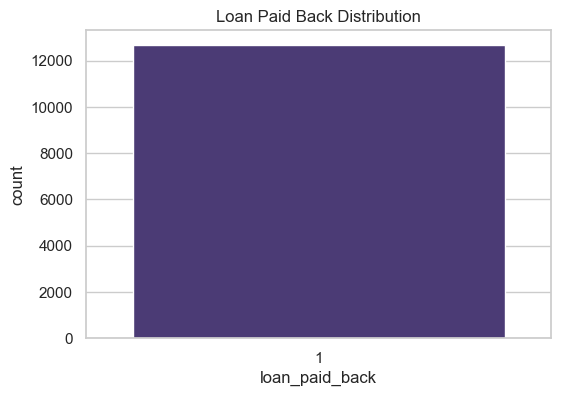

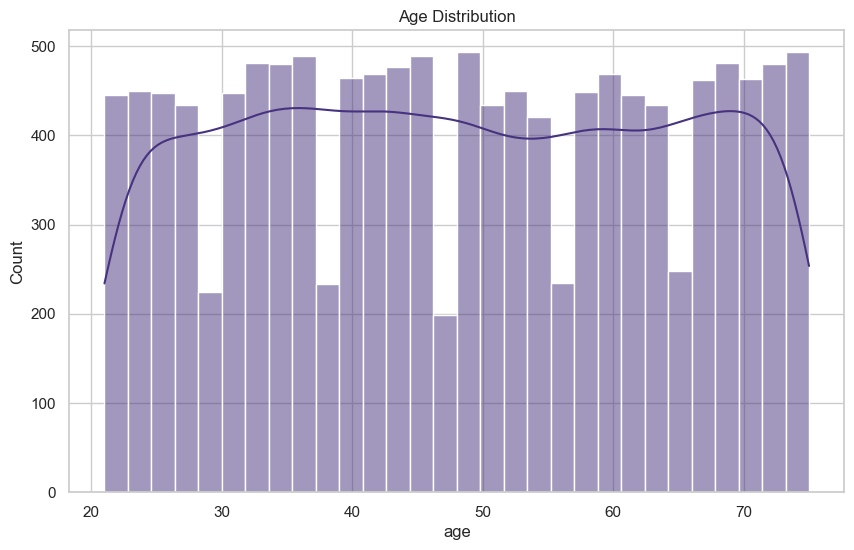

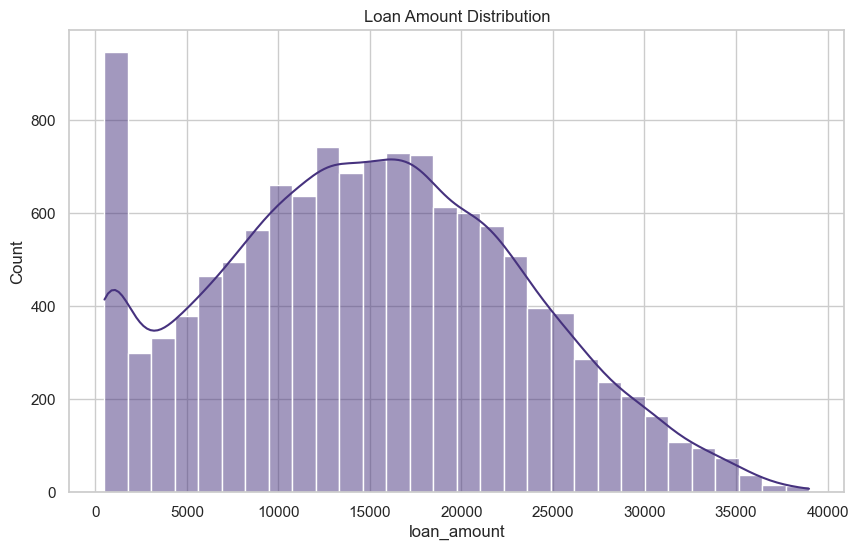

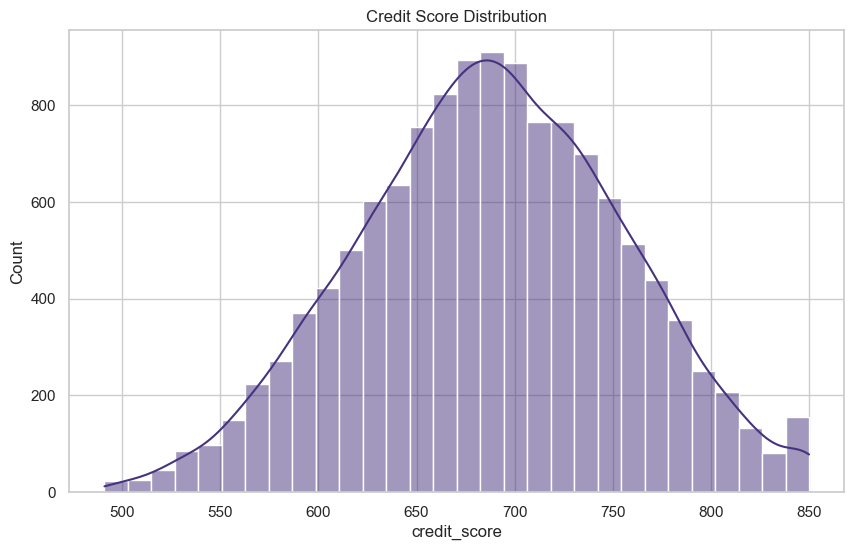

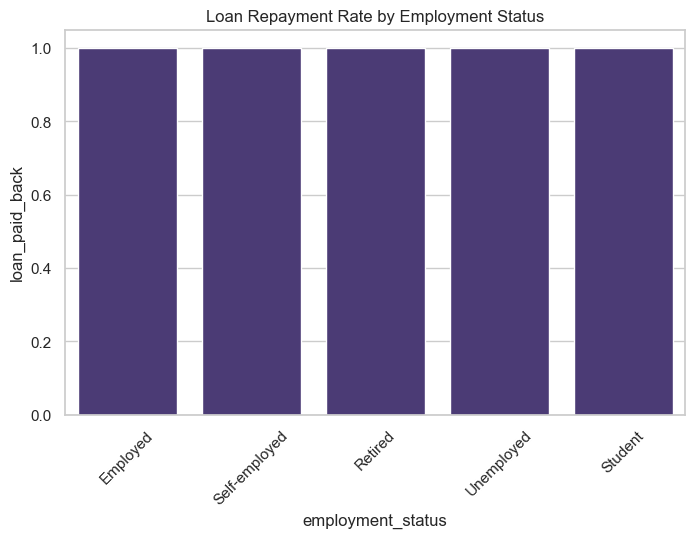

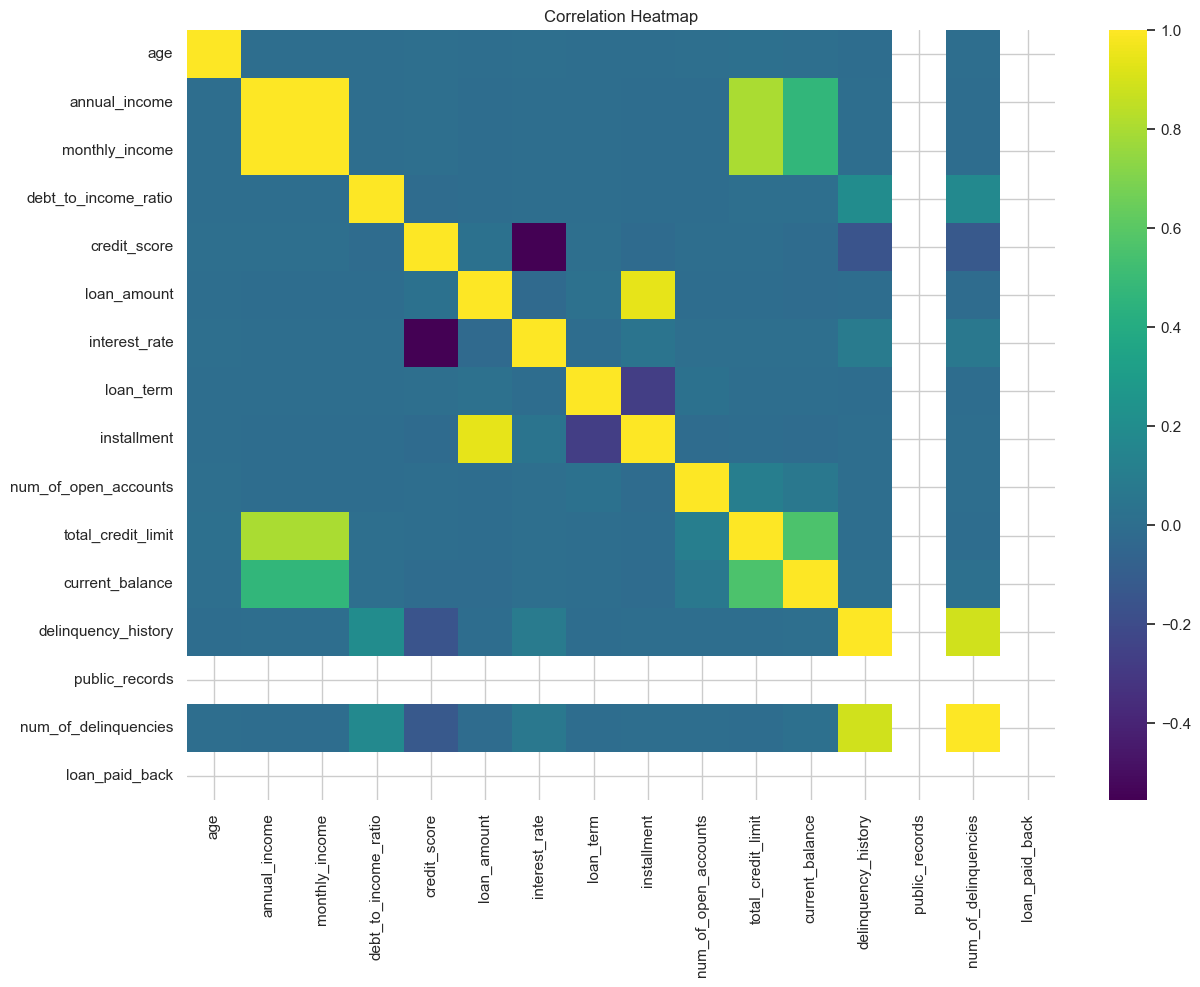


Correlation with loan_paid_back:
age                    NaN
annual_income          NaN
monthly_income         NaN
debt_to_income_ratio   NaN
credit_score           NaN
loan_amount            NaN
interest_rate          NaN
loan_term              NaN
installment            NaN
num_of_open_accounts   NaN
total_credit_limit     NaN
current_balance        NaN
delinquency_history    NaN
public_records         NaN
num_of_delinquencies   NaN
loan_paid_back         NaN
Name: loan_paid_back, dtype: float64


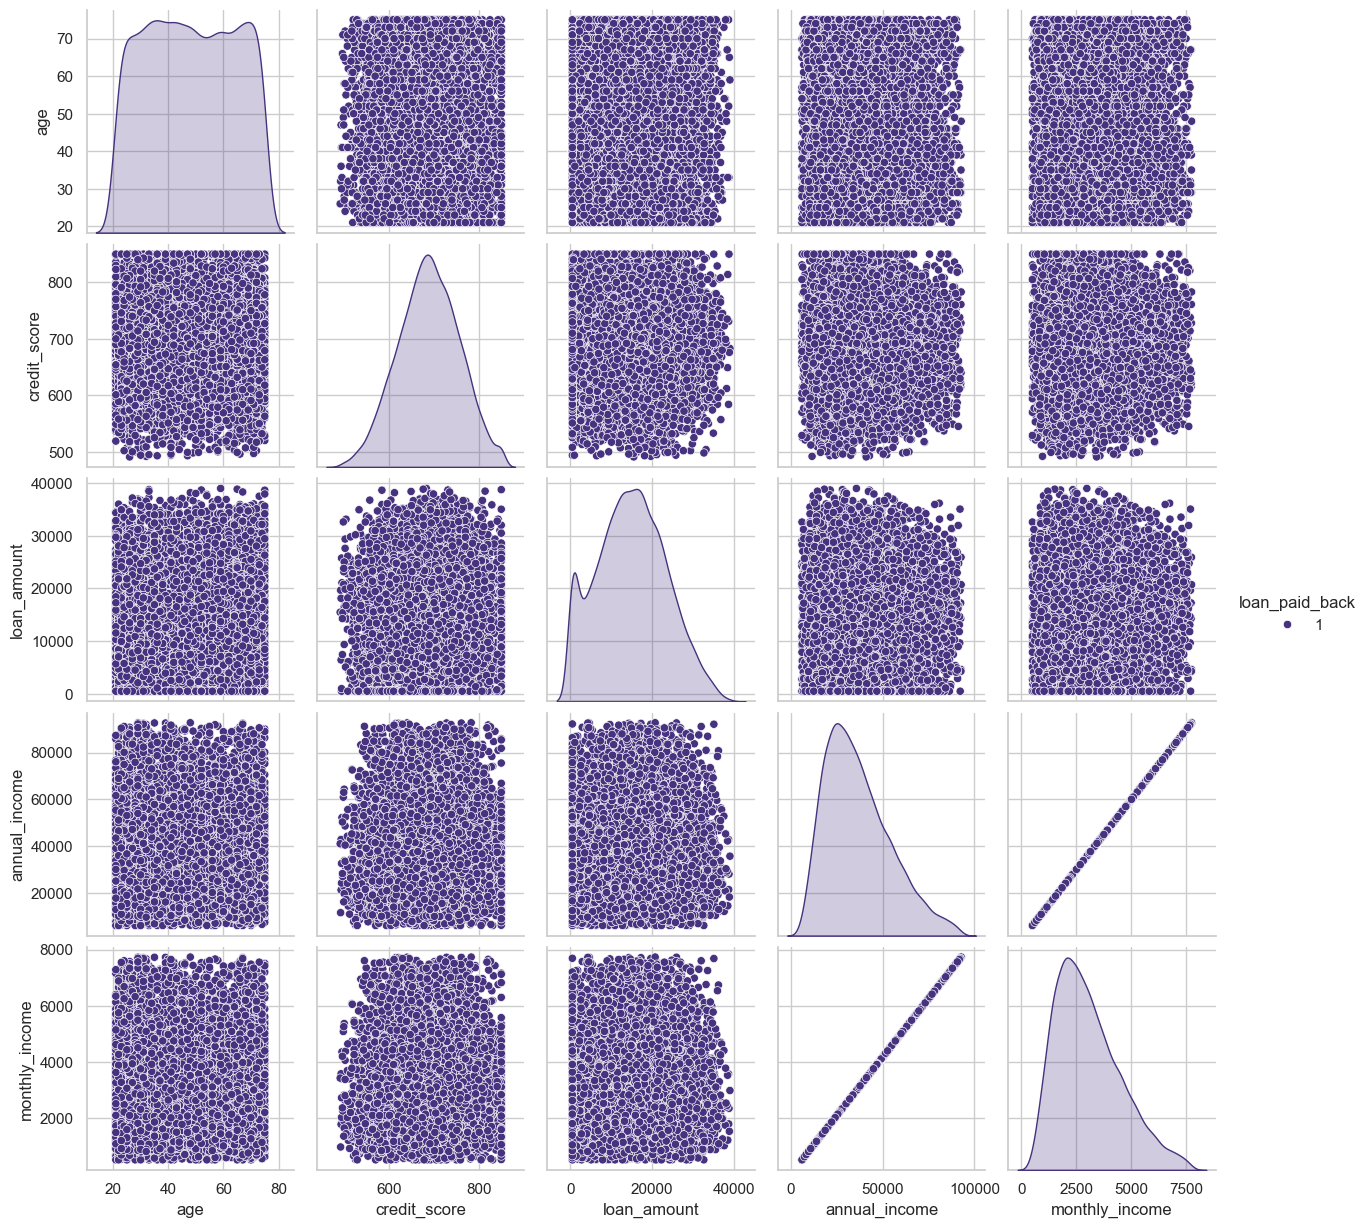

In [1]:
# ------------------------------------------------------------
# 1. IMPORT LIBRARIES
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional settings for nicer visuals
sns.set(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)

# ------------------------------------------------------------
# 2. LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("loan_dataset_20000.csv")

# Quick preview of the dataset
print(df.head())
print(df.info())
print(df.describe())

# ------------------------------------------------------------
# 3. DATA CLEANING
# ------------------------------------------------------------

# --- 3.1 Missing values ---
print("\nMissing values per column:")
print(df.isnull().sum())

# Strategy: fill numerical missing values with median
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical missing values with "Unknown"
cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

# --- 3.2 Remove duplicates ---
df = df.drop_duplicates()

# --- 3.3 Detect outliers using IQR ---
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Remove extreme outliers
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("\nData shape after cleaning:", df.shape)

# ------------------------------------------------------------
# 4. VISUALIZATION OF IMPORTANT VARIABLES
# ------------------------------------------------------------

# --- 4.1 Distribution of target variable ---
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="loan_paid_back")
plt.title("Loan Paid Back Distribution")
plt.show()

# --- 4.2 Age distribution ---
plt.figure()
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# --- 4.3 Loan amount distribution ---
plt.figure()
sns.histplot(df["loan_amount"], bins=30, kde=True)
plt.title("Loan Amount Distribution")
plt.show()

# --- 4.4 Credit score distribution ---
plt.figure()
sns.histplot(df["credit_score"], bins=30, kde=True)
plt.title("Credit Score Distribution")
plt.show()

# --- 4.5 Barplot: default rate per employment status ---
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="employment_status", y="loan_paid_back")
plt.title("Loan Repayment Rate by Employment Status")
plt.xticks(rotation=45)
plt.show()

# ------------------------------------------------------------
# 5. CORRELATION STUDY
# ------------------------------------------------------------

# Only numeric columns for correlation matrix
numeric_df = df[num_cols]

# --- 5.1 Compute correlation matrix ---
correlation_matrix = numeric_df.corr()

# --- 5.2 Heatmap ---
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, annot=False, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

# --- 5.3 Focus on correlations with target variable ---
if "loan_paid_back" in correlation_matrix.columns:
    print("\nCorrelation with loan_paid_back:")
    print(correlation_matrix["loan_paid_back"].sort_values(ascending=False))

# ------------------------------------------------------------
# 6. PAIRPLOT OF IMPORTANT FEATURES (OPTIONAL)
# ------------------------------------------------------------
important_features = ["age", "credit_score", "loan_amount", "annual_income", "monthly_income", "loan_paid_back"]

sns.pairplot(df[important_features], hue="loan_paid_back")
plt.show()


In [6]:
# ------------------------------------------------------------
# 6. MODEL TRAINING : Logistic Regression, Random Forest, XGBoost
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost (install if needed: pip install xgboost)
from xgboost import XGBClassifier


# ------------------------------------------------------------
# 6.1 Split Data
# ------------------------------------------------------------
df = pd.read_csv("loan_dataset_20000.csv")
X = df.drop("loan_paid_back", axis=1)
y = df["loan_paid_back"]

categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ------------------------------------------------------------
# 6.2 Preprocessing Pipeline
# ------------------------------------------------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


# ------------------------------------------------------------
# 7. LOGISTIC REGRESSION
# ------------------------------------------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("\n==========================")
print("LOGISTIC REGRESSION RESULTS")
print("==========================")
print(classification_report(y_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))


# ------------------------------------------------------------
# 8. RANDOM FOREST CLASSIFIER
# ------------------------------------------------------------
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n==========================")
print("RANDOM FOREST RESULTS")
print("==========================")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))


# ------------------------------------------------------------
# 9. XGBOOST CLASSIFIER
# ------------------------------------------------------------
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n==========================")
print("XGBOOST RESULTS")
print("==========================")
print(classification_report(y_test, y_pred_xgb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))


# ------------------------------------------------------------
# 10. PERFORMANCE COMPARISON
# ------------------------------------------------------------
print("\n==========================")
print("MODEL ACCURACY COMPARISON")
print("==========================")
print("Logistic Regression :", accuracy_score(y_test, y_pred_lr))
print("Random Forest       :", accuracy_score(y_test, y_pred_rf))
print("XGBoost             :", accuracy_score(y_test, y_pred_xgb))



LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1001
           1       0.90      0.97      0.93      3999

    accuracy                           0.89      5000
   macro avg       0.85      0.77      0.80      5000
weighted avg       0.88      0.89      0.88      5000

Confusion matrix:
 [[ 575  426]
 [ 139 3860]]

RANDOM FOREST RESULTS
              precision    recall  f1-score   support

           0       0.94      0.53      0.68      1001
           1       0.89      0.99      0.94      3999

    accuracy                           0.90      5000
   macro avg       0.92      0.76      0.81      5000
weighted avg       0.90      0.90      0.89      5000

Confusion matrix:
 [[ 534  467]
 [  34 3965]]

XGBOOST RESULTS
              precision    recall  f1-score   support

           0       0.94      0.55      0.69      1001
           1       0.90      0.99      0.94      3999

    accuracy         

In [8]:
# =============================
# 1. IMPORT LIBRARIES
# =============================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


# =============================
# 2. LOAD YOUR DATASET
# =============================
df = pd.read_csv("loan_dataset_20000.csv")

# Target variable
y = df["loan_paid_back"]

# Features
X = df.drop("loan_paid_back", axis=1)


# =============================
# 3. AUTOMATIC COLUMN DETECTION
# =============================
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


# =============================
# 4. PREPROCESSING PIPELINE
# =============================
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)


# =============================
# 5. MODEL (XGBoost)
# =============================
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        eval_metric='logloss'
    ))
])


# =============================
# 6. TRAIN / TEST SPLIT
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# =============================
# 7. TRAIN MODEL
# =============================
model.fit(X_train, y_train)


# =============================
# 8. PREDICTIONS
# =============================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


# =============================
# 9. EVALUATION
# =============================
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))



Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Numeric columns: ['age', 'annual_income', 'monthly_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term', 'installment', 'num_of_open_accounts', 'total_credit_limit', 'current_balance', 'delinquency_history', 'public_records', 'num_of_delinquencies']
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.53      0.68       818
           1       0.89      0.99      0.94      3182

    accuracy                           0.90      4000
   macro avg       0.92      0.76      0.81      4000
weighted avg       0.90      0.90      0.89      4000


=== Confusion Matrix ===
[[ 432  386]
 [  19 3163]]
